In [1]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from glob import glob
import scipy.io as sio
from scipy import ndimage as nd
from scipy import misc
from scipy.io import loadmat
from tqdm import tqdm
import multiprocessing as mp
import pickle
import math
import matplotlib.pyplot as plt
import PIL.Image as pim
import PIL.ImageOps as pop
import seaborn as sns
%matplotlib inline

In [2]:
sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0, 'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

In [3]:
def applyCropToImg(img, box):
    '''
    applyCropToImg(img, cropBox)
    img ~ any h x w x n image
    cropBox ~ (top, bottom, left, right) in fractions of image size
    '''
    if box[0]+box[1] >= 1:
        raise ValueError('top and bottom crop must sum to less than 1')
    if box[2]+box[3] >= 1:
        raise ValueError('left and right crop must sum to less than 1')
    shape = img.shape
    topCrop = np.round(shape[0]*box[0]).astype(int)
    bottomCrop = np.round(shape[0]*box[1]).astype(int)
    leftCrop = np.round(shape[1]*box[2]).astype(int)
    rightCrop = np.round(shape[1]*box[3]).astype(int)
    croppedImage = img[topCrop:(shape[0]-bottomCrop),leftCrop:(shape[1]-rightCrop)]
    return croppedImage

def maskToIndices(img):
    return img[:,:,0]+img[:,:,1]*256+img[:,:,2]*(256**2)
def maskToUniqueIndices(img):
    imgSegIds = list(np.unique(maskToIndices(img)))
    if 0 in imgSegIds:
        imgSegIds.remove(0)
    return imgSegIds

def maskToUniqueIndices(img):
    imgSegIds = list(np.unique(maskToIndices(img)))
    if 0 in imgSegIds:
        imgSegIds.remove(0)
    return np.unique(imgSegIds)
def getCategoryIDs(annotations, imgSegIds):
    segToCatId = defaultdict(list)
    for ann in annotations:
        for seg in ann['segments_info']:
            segToCatId[seg['id']] = seg['category_id']
    return [segToCatId[s] for s in imgSegIds if s in segToCatId]

def getCategoryNames(catIdToCat, catIds):
    # getCategoryNames(catToCat, catIds)
    return np.unique([catIdToCat[c][0]['name'] for c in catIds])
def getSupercategoryNames(catIdToCat, catIds):
    # getSupercategoryNames(catToCat, catIds)
    return np.unique([catIdToCat[c][0]['supercategory'] for c in catIds])

def supercategoryMap(croppedImg, annotations, embbeding):
    # supercategoryMap(croppedImg, imgIdToAnns[cId], class_embbeding)
    segmentMap = maskToIndices(croppedImg).flatten()
    superMap = np.full(fill_value=-1, shape=segmentMap.shape, dtype=np.int)
    imgSegIds = maskToUniqueIndices(croppedImg)
    catIds = getCategoryIDs(annotations, imgSegIds)
    for c,s in zip(catIds, imgSegIds):
        supercat = getSupercategoryNames(catIdToCat, [c])[0]
        superMap[segmentMap==s] = embbeding[supercat]            
    return superMap.reshape(croppedImg.shape[:2])

In [4]:
exp_design_file = "/SSD/slava/algonauts/algonauts_2023_challenge_data/nsd_expdesign.mat"
exp_design = loadmat(exp_design_file)
print (exp_design.keys())

dict_keys(['__header__', '__version__', '__globals__', 'basiccnt', 'masterordering', 'sharedix', 'stimpattern', 'subjectim'])


In [5]:
basic_cnt    = exp_design['basiccnt']
shared_idx   = exp_design['sharedix']
subject_idx  = exp_design['subjectim']
trial_order  = exp_design['masterordering']
stim_pattern = exp_design['stimpattern']
print (np.min(trial_order), np.max(trial_order))

1 10000


### Expensive code block.

To visualize original nsd images

In [6]:
stim_file = "/SSD/slava/algonauts/algonauts_2023_challenge_data/nsd_stimuli.hdf5"
print ("Loading block...")
image_data_set = h5py.File(stim_file, 'r')
print ('Keys: ', image_data_set.keys())
image_data = np.copy(image_data_set['imgBrick'])
image_data_set.close()
print (image_data.shape)

Loading block...
Keys:  <KeysViewHDF5 ['imgBrick']>
(73000, 425, 425, 3)


In [7]:
print (shared_idx.shape)
print (np.min(shared_idx), np.max(shared_idx))

(1, 1000)
2951 72949


In [8]:
plt.figure(figsize=(10,10))
plt.imshow(mosaic_vis(image_data[shared_idx[0,6:10]-1].astype(np.float32), pad=2), cmap='gray', interpolation='None')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

NameError: name 'mosaic_vis' is not defined

<Figure size 1000x1000 with 0 Axes>

### Coco indices

In [9]:
import pandas as pd
nsd_stiminfo_file = '/SSD/slava/algonauts/algonauts_2023_challenge_data/nsd_stim_info_merged.pkl'
stiminfo = pd.read_pickle(nsd_stiminfo_file)

In [64]:
subject_idx  = exp_design['subjectim']

cocoId_arr = np.zeros(shape=(8, 73000), dtype=int)

for j in range(len(subject_idx)):
    cocoId = np.array(stiminfo['cocoId'])[stiminfo['subject%d'%(j+1)].astype(bool)]
    nsdId = np.array(stiminfo['nsdId'])[stiminfo['subject%d'%(j+1)].astype(bool)]
    assert cocoId.shape == nsdId.shape
    for i in range(nsdId.shape[0]):
        cocoId_arr[j, nsdId[i]] = cocoId[i]
    
cocoId_arr.shape

(8, 73000)

In [10]:
subject_idx  = exp_design['subjectim']
print (subject_idx.shape)

cocoId_arr = np.zeros(shape=subject_idx.shape, dtype=int)
crop_arr   = np.zeros(shape=subject_idx.shape+(4,), dtype=np.float32)
for j in range(len(subject_idx)):
    cocoId = np.array(stiminfo['cocoId'])[stiminfo['subject%d'%(j+1)].astype(bool)]
    nsdId = np.array(stiminfo['nsdId'])[stiminfo['subject%d'%(j+1)].astype(bool)]
    imageId = subject_idx[j]-1
    for i,k in enumerate(imageId):
        cocoId_arr[j,i] = (cocoId[nsdId==k])[0]
        crop_arr[j,i]   = stiminfo['cropBox'][k]

(8, 10000)


In [19]:
import json
from collections import defaultdict

annotations = "/SSD/slava/algonauts/algonauts_2023_challenge_data/annotations/captions_train2017.json"
dataset = json.load(open(annotations, 'r'))

imgIdToAnns = defaultdict(list)

if 'annotations' in dataset:
    for ann in dataset['annotations']:
        imgIdToAnns[ann['image_id']].append(ann)

annotation_val = "/SSD/slava/algonauts/algonauts_2023_challenge_data/annotations/captions_val2017.json"
dataset = dict()
dataset = json.load(open(annotation_val, 'r'))

if 'annotations' in dataset:
    for ann in dataset['annotations']:
        imgIdToAnns[ann['image_id']].append(ann)

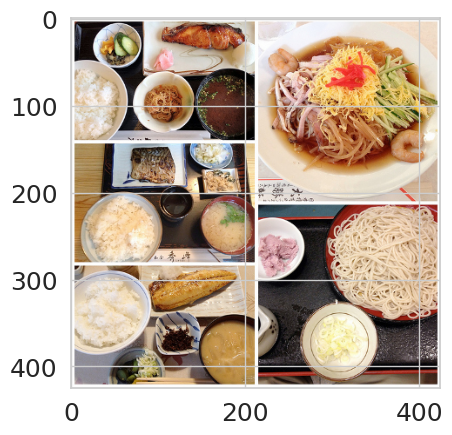

In [42]:
example_image = f"/SSD/slava/algonauts/algonauts_2023_challenge_data/subj01/training_split/training_images/train-0003_nsd-00071.png"
image = pim.open(example_image)
plt.imshow(np.asarray(image))

subject is 1. image id in NSD is 71.

In [67]:
coco_id = cocoId_arr[0, 71]
imgIdToAnns[coco_id]

[{'image_id': 286908,
  'id': 563040,
  'caption': 'Various dishes of food sit in bowls on a table.'},
 {'image_id': 286908,
  'id': 564144,
  'caption': 'A couple of plates of food on a table.'},
 {'image_id': 286908,
  'id': 566031,
  'caption': 'four different pictures of a variety of foods'},
 {'image_id': 286908,
  'id': 567969,
  'caption': 'Several different pictures of various types of food.'},
 {'image_id': 286908,
  'id': 568764,
  'caption': 'A bunch of images of some tasty looking food.'}]

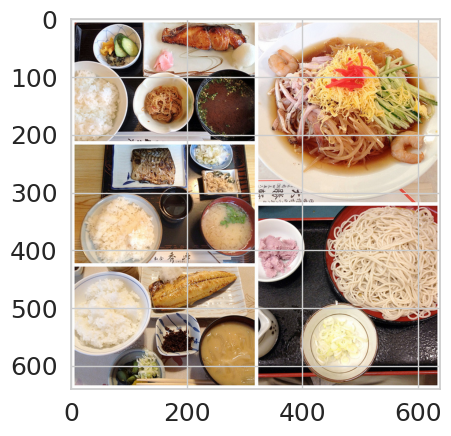

In [68]:
example_image = "/SSD/slava/algonauts/algonauts_2023_challenge_data/val2017/%012d.jpg"%coco_id
image = pim.open(example_image)
plt.imshow(np.asarray(image))